# DrugBank XML → SMILES table

This section reads the DrugBank XML, extracts basic fields (DrugBank ID, name, SMILES, ATC codes), assigns a binary label, performs light cleaning, and writes a flat CSV for downstream analysis.


## Setup

- Libraries: `lxml`/`xml.etree`, `pandas`, `numpy`.
- Data source: `full_database.xml` on Google Drive.
- Namespace: `db: http://www.drugbank.ca` (used in all XPath queries).


In [ ]:
# Install required libraries
!pip install lxml pandas


In [ ]:
import pandas as pd

In [ ]:
# Mount Google Drive to read the DrugBank XML and save outputs
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Load the DrugBank XML file
xml_file_path = '/content/drive/My Drive/full database.xml'

import xml.etree.ElementTree as ET
tree = ET.parse(xml_file_path)
root = tree.getroot()


# XML namespace used by DrugBank
ns = {'db': 'http://www.drugbank.ca'}

print("Loaded from Google Drive")


Loaded from Google Drive


## Parsing logic

For each `<drug>` entry:

1. Read core fields  
   - **ID**: `db:drugbank-id[@primary="true"]`  
   - **Name**: `db:name`  
   - **SMILES**: `db:calculated-properties/db:property[db:kind="SMILES"]/db:value`
2. Collect **ATC codes** from `db:atc-codes/db:atc-code` (list per drug).
3. Assign **Label**: `1` if any ATC code starts with **`L01`** (antineoplastic agents), else `0`.
4. Keep the row only when ID, Name, and SMILES are all present.


In [ ]:
# List to store parsed data
drugs = []

# Loop through each drug entry
for drug in root.findall('db:drug', ns):
    drug_type = drug.attrib.get('type')
    drugbank_id = drug.find('db:drugbank-id[@primary="true"]', ns)
    name = drug.find('db:name', ns)
    smiles = drug.find('db:calculated-properties/db:property[db:kind="SMILES"]/db:value', ns)

    # Get ATC codes
    atc_tags = drug.findall('db:atc-codes/db:atc-code', ns)
    atc_codes = [tag.attrib['code'] for tag in atc_tags]

    # New label: cancer if any ATC code starts with 'L01'
    is_cancer = 1 if any(code.startswith("L01") for code in atc_codes) else 0

    # Add entry only if essential data is present
    if drugbank_id is not None and name is not None and smiles is not None and smiles.text is not None:
        drugs.append({
            'DrugBankID': drugbank_id.text,
            'Name': name.text,
            'SMILES': smiles.text,
            'ATC_Codes': atc_codes,
            'Label': is_cancer
        })


# Print how many cancer drugs were found
num_cancer_drugs = sum(d['Label'] for d in drugs)
print(f"Total cancer drugs found: {num_cancer_drugs} out of {len(drugs)}")

Total cancer drugs found: 225 out of 12313


In [ ]:
# Build a DataFrame from the parsed list
df = pd.DataFrame(drugs)

## Cleaning

- Drop exact duplicates based on **SMILES**.  
- Drop rows with missing **SMILES** or **Label**.  
- Cast **Label** to integer (`0/1`).


In [ ]:
# Drop duplicates based on SMILES string
df.drop_duplicates(subset="SMILES", inplace=True)

# Drop entries with missing SMILES or labels
df.dropna(subset=["SMILES", "Label"], inplace=True)

## Output

- Write the processed table to **`drugbank_smiles_final.csv`**.  
- Save a copy to Google Drive and (optionally) offer a browser download.


In [ ]:
# Save the processed table locally
df.to_csv('drugbank_smiles_final.csv', index=False)

In [ ]:
df.head()

,DrugBankID,Name,SMILES,ATC_Codes,Label
0,DB00006,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,[B01AE06],0
1,DB00014,Goserelin,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,[L02AE03],0
2,DB00027,Gramicidin D,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,[R02AB30],0
3,DB00035,Desmopressin,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,[H01BA02],0
4,DB00050,Cetrorelix,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,[H01CC02],0


In [ ]:
!ls


drive  drugbank_smiles_final.csv  sample_data


In [ ]:
# Save the CSV to Drive
!cp drugbank_smiles_final.csv "/content/drive/My Drive/"


In [ ]:
files.download('drugbank_smiles_final.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Label distribution

- Show counts for `Label==0` and `Label==1`.  
- Plot a simple bar chart titled **“Cancer vs. Non-Cancer Drug Counts”** to document class imbalance for downstream modeling.


In [ ]:
# Label balance
df['Label'].value_counts()


,count
Label,
0,12081
1,225


<Axes: title={'center': 'Cancer vs. Non-Cancer Drug Counts'}, xlabel='Label'>

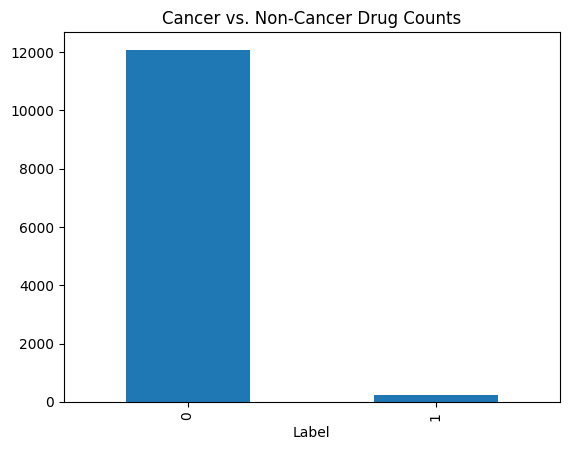

In [ ]:
df['Label'].value_counts().plot(kind='bar', title="Cancer vs. Non-Cancer Drug Counts")
